# 房价预测

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
path = "/content/drive/MyDrive/d2l-zh/Dive-into-DL-PyTorch/code/d2lzh_pytorch" 
os.chdir(path)
!ls

# 然后import库
import sys
sys.path.append("..") # 为了导入上层目录的d2lzh_pytorch
import d2lzh_pytorch as d2l


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
__init__.py  __pycache__  utils.py


In [2]:
drive.mount('/content/drive')
import os
path = "/content/drive/MyDrive" 
os.chdir(path)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'   d2l-zh   mxnet   pytorch   tensorflow


In [3]:
# 防止内核挂掉
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
! nvidia-smi

Tue Nov 29 12:17:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
from torch import nn
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.12.1+cu113


# 1. 使用Pandas读入数据并处理

In [6]:
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/test.csv")
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [7]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


前四个和最后两个特征，以及相应的标签（房价）

In [8]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


在每个样本中，第一个特征是ID，我们将其从数据集中删除，并将train、test数据合并处理

In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.shape)

(2919, 79)


# 2. 数据清洗

In [10]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

## 将所有缺失的值替换为相应特征的平均值。
pandas.DataFrame.fillna 填充第key列的NaN值

In [11]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index # 不是object就是numeric
print(numeric_features)
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean())/(x.std()))
# 标准化后， 每个数值特征均值变为0.所以可以直接用0代替
all_features[numeric_features] = all_features[numeric_features].fillna(0)


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


## 将离散数值转化为指示特征 One-Hot coding
pd.get_dummies()  
例如 假设特征MSZoning里面有两个不同的离散值RL和RM，那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。
如果一个样本原来在MSZoning里的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0。

In [12]:
# dummy_na = True 将缺失值也当作合法的特征并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [13]:
all_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0


## 通过values属性得到Numpy格式数据，并转化为tensor方便后续训练

In [14]:
# 合并集中原先训练集的范围
n_train = train_data.shape[0]
print(n_train)
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice, dtype=torch.float).view(-1, 1)
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)

1460
torch.Size([1460, 331])
torch.Size([1459, 331])
torch.Size([1460, 1])


# 3. 训练模型

## 基本的线性回归模型+平方损失（MSE）函数来训练

In [15]:
loss  = torch.nn.MSELoss()

# 初始化网络参数为正态分布
def get_net(feature_num):
  net = nn.Linear(feature_num, 1)
  for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)
  return net

下面定义比赛用来评价模型的对数均方根误差。

In [16]:
def log_rmse(net, features, labels):
  with torch.no_grad():
    # 将小于1的值设置成1，使得取对数值时更稳定
    clipped_preds = torch.max(net(features), torch.tensor(1.0))
    rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    # 仅包含一个元素的 tensor，那么可以使用 item() 方法来得到对应的 python 数值。
    return rmse.item()

使用了Adam优化算法。  
相对之前使用的小批量随机梯度下降（SGD），它对学习率相对不那么敏感。


In [17]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, 
          learning_rate, weight_decay, batch_size):
  train_ls, test_ls = [], []
  dataset = torch.utils.data.TensorDataset(train_features, train_labels)
  train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
  # 使用Adam优化算法
  optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay)
  net = net.float()
  for epoch in range(num_epochs):
    for X, y in train_iter:
      l = loss(net(X.float()), y.float())
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
    train_ls.append(log_rmse(net, train_features, train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels))
  return train_ls, test_ls

## K折 交叉验证

In [18]:
# k折交叉验证
def get_k_fold_data(k, i, X, y):
  # 返回第i折交叉验证时所需要的训练和验证数据
  assert k > 1
  fold_size = X.shape[0] // k
  X_train, y_train = None, None
  for j in range(k):
    idx = slice(j*fold_size, (j+1)*fold_size)
    X_part, y_part = X[idx, :], y[idx]
    if j == i:
      X_valid, y_valid = X_part, y_part
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      # torch.cat 将两个张量拼接在一起
      X_train = torch.cat((X_train, X_part), 0)
      y_train = torch.cat((y_train, y_part), 0)
  return X_train, y_train, X_valid, y_valid

在K折交叉验证中我们训练K次并返回训练和验证的平均误差。


In [19]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
  train_l_sum, valid_l_sum = 0, 0
  for i in range(k):
    data = get_k_fold_data(k, i, X_train, y_train)
    net = get_net(X_train.shape[1])
    train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i == 0:
      d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
    print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
  return train_l_sum / k, valid_l_sum / k


fold 0, train rmse 0.170152, valid rmse 0.156626
fold 1, train rmse 0.162917, valid rmse 0.192328
fold 2, train rmse 0.163919, valid rmse 0.168288
fold 3, train rmse 0.168116, valid rmse 0.154753
fold 4, train rmse 0.163427, valid rmse 0.183089
5-fold validation: avg train rmse 0.165706, avg valid rmse 0.171017


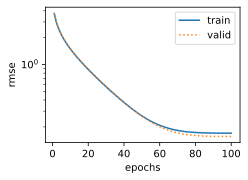

In [20]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

# 模型预测

In [21]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
  net = get_net(train_features.shape[1])
  train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
  print('train rmse %f' % train_ls[-1])
    # detach 返回
  pred = net(test_features).detach().numpy()
  test_data['SalePrice'] = pd.Series(pred.reshape(1, -1)[0])
  submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1) # axis=1沿着列方向水平拼接
  submission.to_csv('./submission.csv', index=False)


In [22]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

train rmse 0.162392


In [23]:
!pwd

/content/drive/MyDrive
